In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
#import wandb

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02514/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 224
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])


batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

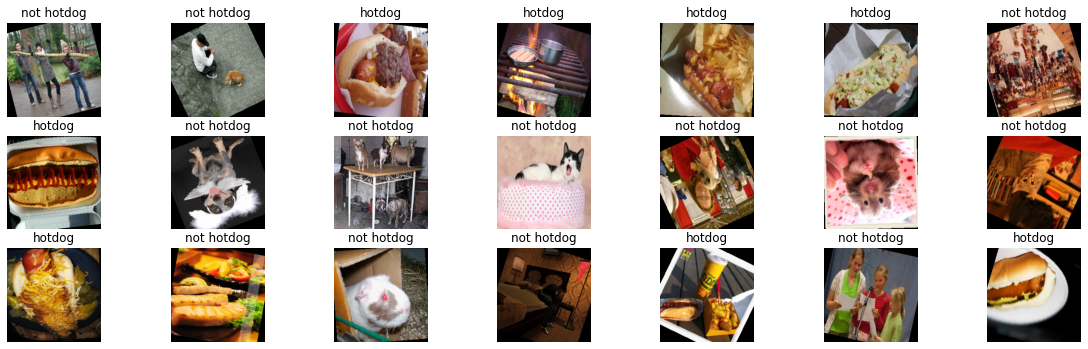

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

Now create a model and train it!


In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        loss = nn.CrossEntropyLoss()
        return loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    patience = 0
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
        
        wandb.log({"train_acc": out_dict['train_acc'][-1],
                  "test_acc": out_dict['test_acc'][-1],
                  "train_loss": out_dict['train_loss'][-1],
                   "test_loss": out_dict['test_loss'][-1]})      
        
        if out_dict['test_loss'][-1] > min(out_dict['test_loss']):
            patience += 1 
        else: 
            patience = 0
            
        if patience == 5:
            print("EARLY STOPPED!")
            break 
       
    return out_dict

In [7]:
class VGG_Network(nn.Module):
    def __init__(self):
        super(VGG_Network, self).__init__()       
        
        self.convolutional = nn.Sequential(
               nn.Conv2d(3, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.Conv2d(64, 64, 3, stride=1, padding=1),
               nn.BatchNorm2d(64),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(64, 128, 3, stride=1, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.Conv2d(128, 128, 3, stride=1, padding=1),
               nn.BatchNorm2d(128),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(128, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.Conv2d(256, 256, 3, stride=1, padding=1),
               nn.BatchNorm2d(256),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(256, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.Conv2d(512, 512, 3, stride=1, padding=1),
               nn.BatchNorm2d(512),
               nn.ReLU(),
               nn.MaxPool2d(2, 2),
               #nn.Dropout(p=0.2)
               )

        self.fully_connected = nn.Sequential(
                nn.Linear(7*7*512, 4096),               
                nn.ReLU(),            
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 4096),              
                nn.ReLU(),
                #nn.Dropout(p=0.2),
                nn.Linear(4096, 2))
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [8]:
model_SGD = VGG_Network()
model_ADAM = VGG_Network()

model_SGD.to(device)
model_ADAM.to(device)

#Initialize the optimizer
SGD_lr = 0.001
ADAM_lr = 0.00001
optimizer_SGD = torch.optim.SGD(model_SGD.parameters(), lr=SGD_lr)
optimizer_ADAM = torch.optim.Adam(model_ADAM.parameters(),lr=ADAM_lr)

num_epoch = 30

wandb: Currently logged in as: gizemggungor. Use `wandb login --relogin` to force relogin


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.679	 test: 0.698	 Accuracy train: 56.7%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.645	 test: 0.674	 Accuracy train: 65.6%	 test: 56.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.614	 test: 0.615	 Accuracy train: 67.8%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.579	 test: 0.597	 Accuracy train: 70.3%	 test: 69.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.555	 test: 0.579	 Accuracy train: 72.9%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.533	 test: 0.551	 Accuracy train: 74.5%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.545	 Accuracy train: 75.0%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.502	 test: 0.529	 Accuracy train: 76.7%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.496	 test: 0.533	 Accuracy train: 77.8%	 test: 75.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.477	 test: 0.510	 Accuracy train: 79.0%	 test: 76.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.462	 test: 0.501	 Accuracy train: 79.7%	 test: 76.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.447	 test: 0.502	 Accuracy train: 80.2%	 test: 76.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.437	 test: 0.505	 Accuracy train: 80.3%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.416	 test: 0.488	 Accuracy train: 81.5%	 test: 77.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.421	 test: 0.507	 Accuracy train: 80.7%	 test: 76.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.406	 test: 0.495	 Accuracy train: 82.1%	 test: 77.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.387	 test: 0.467	 Accuracy train: 83.7%	 test: 77.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.382	 test: 0.520	 Accuracy train: 83.3%	 test: 77.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.372	 test: 0.444	 Accuracy train: 83.8%	 test: 80.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.369	 test: 0.457	 Accuracy train: 83.8%	 test: 79.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.360	 test: 0.485	 Accuracy train: 84.3%	 test: 78.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.355	 test: 0.510	 Accuracy train: 84.5%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.350	 test: 0.426	 Accuracy train: 84.3%	 test: 80.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.345	 test: 0.470	 Accuracy train: 85.0%	 test: 79.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.326	 test: 0.491	 Accuracy train: 86.2%	 test: 78.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.335	 test: 0.429	 Accuracy train: 85.4%	 test: 81.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.325	 test: 0.467	 Accuracy train: 86.3%	 test: 80.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.320	 test: 0.424	 Accuracy train: 86.1%	 test: 80.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.314	 test: 0.435	 Accuracy train: 87.5%	 test: 80.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.311	 test: 0.496	 Accuracy train: 86.8%	 test: 78.3%


test_acc,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇████▇
test_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▃▃▁▂▃▁▂▁▁▃
train_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
test_acc,0.78303
test_loss,0.49648
train_acc,0.86761
train_loss,0.3113


  0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.622	 test: 0.687	 Accuracy train: 64.3%	 test: 51.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.663	 Accuracy train: 75.5%	 test: 67.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.501	 Accuracy train: 77.2%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.440	 test: 0.472	 Accuracy train: 80.3%	 test: 78.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.409	 test: 0.458	 Accuracy train: 81.9%	 test: 78.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.381	 test: 0.505	 Accuracy train: 83.3%	 test: 77.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.375	 test: 0.471	 Accuracy train: 83.8%	 test: 79.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.353	 test: 0.435	 Accuracy train: 84.9%	 test: 80.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.341	 test: 0.439	 Accuracy train: 85.3%	 test: 79.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.317	 test: 0.440	 Accuracy train: 86.0%	 test: 80.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.300	 test: 0.465	 Accuracy train: 86.8%	 test: 80.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.310	 test: 0.485	 Accuracy train: 86.9%	 test: 79.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.295	 test: 0.657	 Accuracy train: 88.3%	 test: 77.7%
EARLY STOPPED!


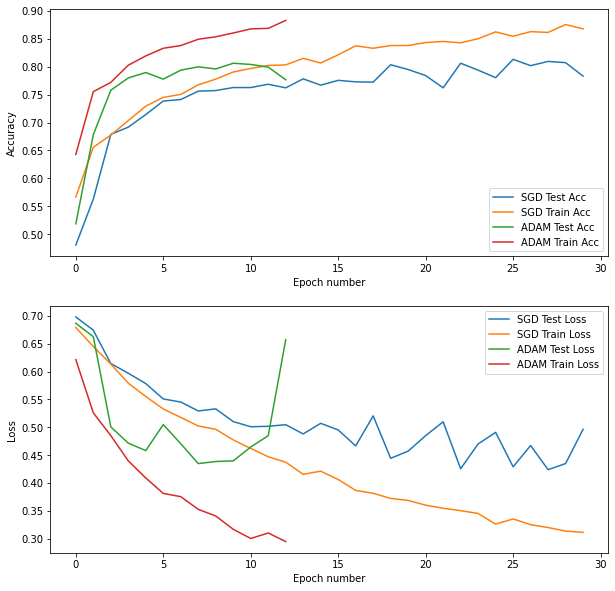

In [9]:
#wandb.init(project="Hotdog", name="VGG_SGD", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": SGD_lr,
#  "epochs": num_epoch,
#  "optimizer" : "SGD",
#  "predefined" : False,
#  "data_augmentation" : True,    
#  "batch_norm" : True, 
#  "dropout" : False 
#})

out_dict = train(model_SGD, optimizer_SGD, num_epoch)
fig, ax = plt.subplots(2,1,figsize=(10, 10))
ax[0].plot(out_dict["test_acc"], label='SGD Test Acc')
ax[0].plot(out_dict["train_acc"], label='SGD Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
 

ax[1].plot(out_dict["test_loss"], label='SGD Test Loss')
ax[1].plot(out_dict["train_loss"], label='SGD Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

#wandb.init(project="Hotdog", name="VGG_ADAM", entity="gizemggungor")
#wandb.config.update({
#  "learning_rate": ADAM_lr,
#  "epochs": num_epoch,
#  "optimizer" : "ADAM",
#  "predefined" : False,
#  "data_augmentation" : True,
#  "batch_norm" : True, 
#  "dropout" : False     
#})
out_dict = train(model_ADAM, optimizer_ADAM, num_epoch)
ax[0].plot(out_dict["test_acc"], label='ADAM Test Acc')
ax[0].plot(out_dict["train_acc"], label='ADAM Train Acc')
ax[0].set_xlabel('Epoch number')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(out_dict["test_loss"], label='ADAM Test Loss')
ax[1].plot(out_dict["train_loss"], label='ADAM Train Loss')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
ax[1].legend()